## Пример эквивалентности норм

Все нормы в конечномерном пространстве эквивалентны. Это утверждение означает, что для любых двух норм найдётся неотрицательные константы $C_1, C_2 \geq 0$ такие что

$$ C_1 \| \cdot \|_{*} \leq \| \cdot \|_{**} \leq C_2 \| \cdot\|_*$$

Покажем это на конкретных примерах для норм $\|\cdot\|_2, \|\cdot\|_1, \|\cdot\|_{\infty}$

## Поиск максимума

Для рассмотренных норм можно построить сопряжённые нормы с помощью следующего определения

$$ \|z\|_* = \max_{\|x\| \leq 1} (z, x). $$

Найдём сопряжённую норму для евклидовой нормы. 

## Вычисление произведения матриц

$$ C = AB \quad c_{ij} = \sum_{k=1}^m a_{ik}b_{kj} $$

In [ ]:
import numpy as np
from numba import jit

def matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]  
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
                
    return c

@jit(nopython=True)
def numba_matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

n = 500
a = np.random.randn(n, n)
b = np.random.randn(n, n)

%timeit numba_matmul(a, b)
%timeit numba_matmul_isj(a, b)
%timeit np.dot(a, b)

## Приложение: рекомендательные системы

### Что дано?

- Матрица пользователь-продукт
- Элементы матрицы – рейтинги, если есть
- Неполное заполнение

## Как использовать SVD?

- Оригинальная работа [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Построим вложение пользователей и продуктов в некоторое подпространство $\mathbb{R}^n$
- Для известных предпочтений найдём наиболее близкие продукты в этом подпространстве
- Как это вычислительно сделать?

### Датасет Movielens с рейтингами фильмов

In [61]:
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Пример записей

In [62]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [64]:
ratings

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [65]:
ratings[['userid', 'movieid']].apply(pd.Series.nunique)

userid     6040
movieid    3706
dtype: int64

### Зададим список предпочтений

In [90]:
best_movies = "Godfather"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
858,"Godfather, The (1972)","Action, Crime, Drama"
1221,"Godfather: Part II, The (1974)","Action, Crime, Drama"
2023,"Godfather: Part III, The (1990)","Action, Crime, Drama"


### Выделим индексы выбранных фильмов

In [91]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([858, 1221, 2023], dtype='int64', name='movieid')


### Создадим матрицу с рейтингами 

In [85]:
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Вычислим SVD

In [86]:
rank = 50
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

### Посмотрим на убывание сингулярных чисел

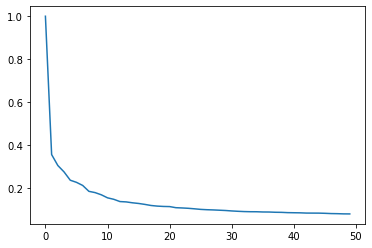

In [87]:
plt.plot(S[::-1] / S[-1])

### Получим корреляции

In [92]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(50, 3)
(3953, 3)
(3953,)


### Вычислим итоговые рекомендации

In [93]:
top_n = 20
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.8412151  0.72298478 0.20254655 0.12884495 0.12727929 0.11651275
 0.10928934 0.10901711 0.09848998 0.09220464 0.08291223 0.07980152
 0.07433467 0.0699485  0.06720786 0.06554852 0.05886816 0.05670393
 0.0564577  0.0531071 ]


,movienm,genreid
movieid,,
858,"Godfather, The (1972)","Action, Crime, Drama"
1221,"Godfather: Part II, The (1974)","Action, Crime, Drama"
2023,"Godfather: Part III, The (1990)","Action, Crime, Drama"
1213,GoodFellas (1990),"Crime, Drama"
1953,"French Connection, The (1971)","Action, Crime, Drama, Thriller"
912,Casablanca (1942),"Drama, Romance, War"
111,Taxi Driver (1976),"Drama, Thriller"
923,Citizen Kane (1941),Drama
2019,Seven Samurai (The Magnificent Seven) (Shichin...,"Action, Drama"


### Обобщения 

- Учёт контекста позволяет внести в скалярное произведение матрицу похожести. Получим гибридную модель SVD, подробности в [этой работе](https://arxiv.org/pdf/1802.06398.pdf)
- Обзор использования нейронных сетей в рекомендательных системах можно найти [тут](https://arxiv.org/pdf/1707.07435.pdf): неочевидные преимущества по сравнению с моделями, основанными на матричных разложениях